In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, chi2, rv_continuous
from scipy.special import gamma, factorial
from scipy.optimize import fsolve, root, brentq, brenth, ridder, newton, minimize
import seaborn as sns

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
   "figure.figsize" : (6,5)})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

<h3>Step 1: Build likelihood function:</h3>
The simplest Likelihood function (without considering nuisance parameters) is given by:

$$ L(\mu,\theta) = \frac{(\mu s + b + \theta)^{n}}{n!}e^{-(\mu s + b + \theta)} \pi(\theta)$$

where $\pi(\theta)$ is the nuisance PDF taken to be given by:

$$
\pi(\theta) = \frac{1}{\sqrt{2\pi}\delta}e^{-\frac{\theta^2}{2\delta^2}}
$$
where $\delta$ is the background systematic uncertainty. Therefore:

$$
L(\mu,\theta) = \frac{1}{\sqrt{2\pi}\delta} \frac{(\mu s + b + \theta)^{n}}{n!}e^{-(\mu s + b + \theta)}e^{-\frac{\theta^2}{2\delta^2}}
$$

In [2]:
# define factorial
# likelihood function

class theta_gen(rv_continuous):
    """
    Distribution for nuiscance parameter.
    (it can be used to generate random theta values based on the
    piTheta function. But it is extremely slow, unless the _ppf is defined).
    It has the following useful methods: .pdf (probability density function),
    .cdf (cumulative density function), .ppf (percent point function or inverse of cdf),
    .rvs (random number generator).
    """

    def _pdf(self, theta, deltab):
        return norm.pdf(theta,scale=deltab)
    
    def _cdf(self,theta,deltab):
        return norm.cdf(theta,scale=deltab)    
    
    def _ppf(self,q,deltab):
        return norm.ppf(q,scale=deltab)

# Define nuisance instance:
piTheta = theta_gen(name='piTheta')

def likelihood(muTheta:list, n : int, nb : float, ns : float, deltab=0.0,nll=False) -> float:
    '''
    Obtain the Likelihood for a specific set of data
    n : # observed of events
    nb : # of background events
    ns : # of signal events
    mu : strength parameter
    theta: nuisance parameter
    deltab: uncertainty for the nuisance parameter
    '''        
    
    mu,theta = muTheta
        
    ntot = nb + mu*ns + theta
    # Make sure ntot is not negative:
    ntot = max(0.,ntot)
    prob = poisson.pmf(n, ntot)
    if deltab > 0.:
        prob = prob*piTheta.pdf(theta,deltab)
    if nll:
        return -np.log(prob)
    else:
        return prob
    
def thetaHat(mu:float, n : int, nb : float, ns : float, 
             deltab=0.0, tol=1e-2, method='analytic') -> (float,None):
    """
    Returns the value of theta which maximizes the likelihood
    for fixed values of mu,n,nb,ns and deltab.
    """
    
    if method == 'analytic':
        ntot = mu*ns+nb
        a = -(1./2.)*(deltab**2+ntot)
        b = (1./2.)*np.sqrt((ntot-deltab**2)**2+4*deltab**2*n)
        thetaH1 = a+b
        thetaH2 = a-b
        l1 = likelihood((mu,thetaH1),n,nb,ns,deltab)
        l2 = likelihood((mu,thetaH2),n,nb,ns,deltab)
        if l1 > l2:
            return thetaH1
        else:
            return thetaH2
  
    #Initial guess for thetaHat:
    thetaH = n-nb-mu*ns
        
    #Bounds for mu:
    muMin = mu
    muMax = mu
    
    r = minimize(likelihood,(mu,thetaH),args=(n,nb,ns,deltab,True),method='Nelder-Mead',
             bounds=[(muMin,muMax),(None,None)],tol=tol)
    
    if not r.success:
        return None
    else:
        muH,thetaH = r.x        
        return thetaH
    
    
    
def muThetaHat(n : int, nb : float, ns : float, 
               deltab=0.0,tol=1e-2, allowNegativeMu=False,
               method='analytic') -> (list,None):
    """
    Returns the value of mu and theta which maximizes the likelihood
    for fixed values of n,nb,ns and deltab.
    """
    
    if method == 'analytic':
        muH = (n-nb)/ns        
        thetaH = 0.0
        if not allowNegativeMu and muH < 0.:
            muH = 0.
            thetaH = thetaHat(muH, n, nb, ns, deltab,
                              method='analytic')
        return muH,thetaH
            
    
    
    #Initial guess for muHat and thetaHat:
    muH = (n - nb)/ns
    # If muHat >0, we know thetaHat = 0.0
    if muH >=0.:
        thetaH = 0.0
    # If muHat < 0.0, thetaHat will have to be negative
    # (as a first guess use muHat = 0., thetaHat = (n-nb)
    else:
        thetaH = n-nb
        muH = 0.0
        
    #Bounds for mu:
    muMin,muMax = None,None
    if not allowNegativeMu:
        muMin = 0.0
    
    r = minimize(likelihood,(muH,thetaH),args=(n,nb,ns,deltab,True),
                 method='Nelder-Mead',
                 bounds=[(muMin,muMax),(None,None)],tol=tol)
    
    if not r.success:
        return None
    else:
        muH,thetaH = r.x        
        return muH,thetaH
    
def maxLikelihood(n:int, nb:float, ns:float, deltab=0.0, nll=False) -> float:
    
    #Get values for muHat and thetaHat:
    muH,thetaH = muThetaHat(n,nb,ns,deltab)
    
    Lmax = likelihood((muH,thetaH),n,nb,ns,deltab,nll)
    
    return Lmax

def qtest(mu, n, nb, ns, deltab, allowNegativeMu=False):
    
    if not allowNegativeMu:
        mu = max(mu,0.)
    #Get values for mu and theta for the maximum likelihood:
    # (mu is contrained to be positive)
    muH,thetaH = muThetaHat(n,nb,ns,deltab,allowNegativeMu=allowNegativeMu)
    # If muHat > mu -> signal is compatible:
    # (see Eq.16 in arxiv:1007.1727)
    if muH > mu and not allowNegativeMu:
        return 0.0
   
    # Maximum likelihood
    Lmax = likelihood((muH,thetaH),n,nb,ns,deltab,nll=True)
    
    # Get nuisance estimator for the signal
    thetaHH = thetaHat(mu, n, nb, ns, deltab)
    L = likelihood((mu,thetaHH),n, nb, ns, deltab,nll=True)
    
    q = 2*(L-Lmax)
    
    return q
    
# Generate samples
def genData(mu:float, nb:float, ns:float, deltab:float, nsim:(float,int)) -> list:
    
    # Make sure it is an int
    nsim = int(nsim)
    # First draw thetas from their random variable
    # instance:
    theta_random = piTheta.rvs(size=nsim,deltab=deltab)
    
    # For a given mu, generate random
    # observed data using the poisson distribution
    # for lambda = mu*ns + nb + theta_random
    n_gen = []
    for theta in theta_random:
        lam = mu*ns+nb+theta
        # Make sure the total number of events
        # is positive
        if lam <= 0.0:
            continue
        n = np.random.poisson(lam=lam, size=1)[0]
        n_gen.append(n)
    
    return n_gen

def pValue(mu, nobs, nb, ns, deltab, Nmin=1e2, Nmax=1e3, 
           rel_err=1e-1, abs_err=1e-3,allowNegativeMu=False):
    """
    Compute p-value for fixed values of mu, nobs, nb, ns and deltab.
    
    :param Nmin: minimum number of pseudo experiments to generate
    :param Nmax: maximum number of pseudo experiments to generate
    :param rel_err: Maximum relative error for p-value result
    
    :return: p-value and its error
    """
    
    # Make sure limits are integers
    Nmax = int(Nmax)
    Nmin = int(Nmin)
    
    # Observed q:
    qobs = qtest(mu, nobs, nb, ns, deltab,allowNegativeMu=allowNegativeMu)
    
    # First generate a large random data sample (cheap):   
    pseudoN = genData(mu, nb, ns, deltab, Nmax)
    
    # Compute p-value using the first Nmin experiments:
    q_mu = np.array([qtest(mu, n, nb, ns, deltab,allowNegativeMu=allowNegativeMu) for n in pseudoN[:Nmin]])
    pvalue = len(q_mu[q_mu > qobs])/len(q_mu)
        
    # Loop over pseudo experiments and update p-value until it
    # converges:
    nconv = 0
    for i,n in enumerate(pseudoN[Nmin:]):
        q = qtest(mu, n, nb, ns, deltab,allowNegativeMu=allowNegativeMu)
        # Update q values
        q_mu = np.append(q_mu,q)
        # Update p-value:
        q_higher = len(q_mu[q_mu > qobs])
        p = q_higher/len(q_mu)
        if q_higher == 0:
            # In this case use the minimum 
            # absolute error as qhigher = 1            
            pErr = 1.0
            absErr = 1.0 
        else:
            # Compute absolute and relative error on p-value
            # (take into accound the statistical error
            # on the number of q-values above q_obs)            
            absErr = max(abs(pvalue-p),np.sqrt(q_higher))
            pErr = max(abs(pvalue-p)/p,1./np.sqrt(q_higher))
        
        pvalue = p
        # Compute how many consecutive iterations
        # have converged:
        if (pErr < rel_err or absErr < abs_err):
            nconv += 1
        else:
            nconv = 0
        # If it has converged for
        # two consecutive iterations, stop
        if nconv > 2:
            return pvalue,pErr,absErr,i+Nmin
            
    
    print('Maximum number of pseudo experiments exceeded for mu = %1.2f.' %mu)
    
    return pvalue,pErr,absErr,i+Nmin


def muUL(nobs, nb, ns, deltab, Nmin=5e2,Nmax=1e3,allowNegativeMu=False,
         rtol=1e-2,method='brentq'):
    
    p0 = pValue(0,nobs,nb,ns,deltab,Nmin,Nmax,allowNegativeMu=allowNegativeMu)[0]
    
    def rootCLs(mu,nobs,nb,ns,deltab,Nmin,Nmax,allowNegativeMu):
        pmu = pValue(mu,nobs,nb,ns,deltab,Nmin,Nmax,allowNegativeMu=allowNegativeMu)[0]
        CLs = pmu/(1.0-p0)
        
        return CLs-0.05

    # mu can at least be as small as given by nobs = nb + mu*ns:
    mu_min = (nobs-nb)/ns
    # Assume mu_max can be at most at 5sigma
    mu_max = (nobs-(nb-5*deltab))/ns
    # Initial guess for mu_ul:
    # (assume nb fluctuates 2sigma down)
    mu_guess = nobs-(nb-2*deltab)/ns

    if not allowNegativeMu:
        mu_min = max(0.,mu_min)
        mu_guess = max(0.,mu_guess)
    
    
    if method == 'brentq':
        mu_ul,r = brentq(rootCLs,mu_min,mu_max,
                   args=(nobs,nb,ns,deltab,Nmin,Nmax,allowNegativeMu),
                   rtol=rtol, full_output=True)
    elif method == 'brenth':
        mu_ul,r = brenth(rootCLs,mu_min,mu_max,
                   args=(nobs,nb,ns,deltab,Nmin,Nmax,allowNegativeMu),
                   rtol=rtol, full_output=True)        
    elif method == 'newton':
        mu_ul,r = newton(rootCLs, mu_guess, 
                         args=(nobs,nb,ns,deltab,Nmin,Nmax,allowNegativeMu), 
                         rtol=rtol, full_output=True)
    elif method == 'ridder':
        mu_ul,r = ridder(rootCLs,mu_min,mu_max,
                   args=(nobs,nb,ns,deltab,Nmin,Nmax,allowNegativeMu),
                   rtol=rtol, full_output=True)
        
    if not r.converged:
        return None
    else:
        return mu_ul

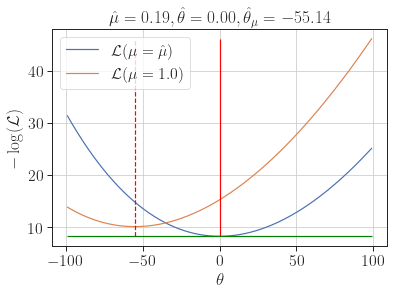

In [3]:
n = nobs = 331
nb = 314.0
deltab = 33.0
ns =  0.646*139.0
mu = 1.0
nll = True
thetavals = np.linspace(-3*deltab,3*deltab,300)
muH,thetaH = muThetaHat(n,nb,ns,deltab)
thetaHH = thetaHat(mu,n,nb,ns,deltab)
lmax = maxLikelihood(n,nb,ns,deltab,nll=nll)
l = [likelihood((muH,t),n,nb,ns,deltab,nll=nll)for t in thetavals]
lmu = [likelihood((mu,t),n,nb,ns,deltab,nll=nll)for t in thetavals]
plt.plot(thetavals,l,label=r'$\mathcal{L}(\mu=\hat{\mu})$')
plt.plot(thetavals,lmu,label=r'$\mathcal{L}(\mu=%1.1f)$' %mu)
plt.vlines(x=thetaH,ymin=min(min(l),min(lmu)),ymax=max(max(l),max(lmu)),color='red')
plt.vlines(x=thetaHH,ymin=min(min(l),min(lmu)),ymax=max(max(l),max(lmu)),color='red',linestyle='--')
plt.hlines(y=lmax,xmin=thetavals.min(),xmax=thetavals.max(),color='green')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$-\log(\mathcal{L})$')
plt.title(r'$\hat{\mu} = %1.2f, \hat{\theta} = %1.2f, \hat{\theta}_{\mu} = %1.2f$' %(muH,thetaH,thetaHH))
plt.legend()
plt.grid()
plt.show()

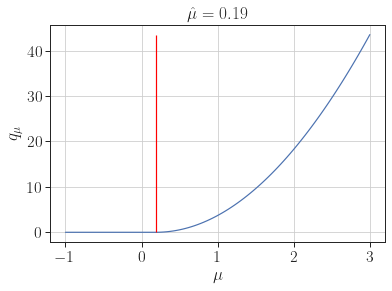

In [4]:
muvals = np.linspace(-1.,3,100)
muH,thetaH = muThetaHat(n,nb,ns,deltab)
l = [qtest(mu,n,nb,ns,deltab) for mu in muvals]
plt.plot(muvals,l)
plt.vlines(x=muH,ymin=min(l),ymax=max(l),color='red')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$q_\mu$')
plt.title(r'$\hat{\mu} = %1.2f$' %(muH))
plt.grid()
plt.show()

In [5]:
# Generate pseudo data
nsim = 1e5
pseudoN = genData(mu, nb, ns, deltab, nsim)

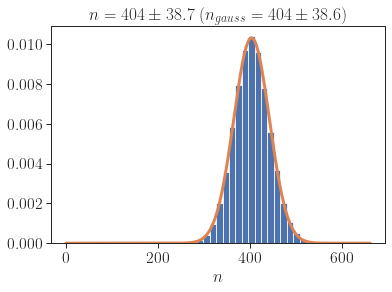

In [6]:
# Plot pseudo data
n_mean,n_std = np.mean(pseudoN),np.std(pseudoN)

n_mean_app, n_std_app = nb+mu*ns,np.sqrt((nb+mu*ns)+deltab**2)

plt.hist(pseudoN,bins=25,density=True)
plt.title(r'$n = %1.0f \pm %1.1f$ ($n_{gauss} = %1.0f \pm %1.1f$)' %(n_mean,n_std,n_mean_app,n_std_app))
xvals = np.linspace(0,2*nobs,1000)
plt.xlabel(r'$n$')
plt.plot(xvals,norm.pdf(xvals,loc=n_mean_app,scale=n_std_app),linewidth=3)
plt.show()

In [7]:
%%time
#Compute q values
qmu = np.array([qtest(mu, n, nb, ns, deltab) for n in pseudoN[:30000]])

CPU times: user 12.5 s, sys: 35.3 ms, total: 12.5 s
Wall time: 12.5 s


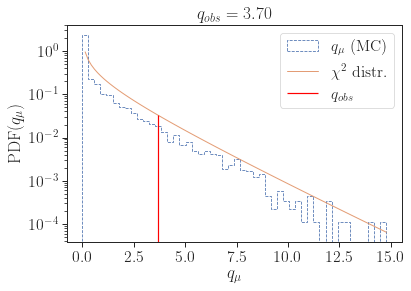

In [8]:
qobs = qtest(mu, nobs, nb, ns, deltab)
qvals = np.linspace(qmu.min(), qmu.max(), 100)
# Plot histogram
hist = plt.hist(qmu, bins=50, density=True, linestyle='--', histtype='step', label=r'$q_{\mu}$ (MC)')
plt.plot(qvals, chi2.pdf(qvals, df=1), linewidth=1, alpha=0.8, label=r'$\chi^{2}$ distr.')
plt.vlines(qobs, 0, chi2.pdf(qobs, df=1), 'red', label=r'$q_{obs}$')
plt.title(r'$q_{obs} = %1.2f$'%qobs)
plt.legend()
plt.ylabel(r'PDF($q_{\mu}$)')
plt.xlabel(r'$q_{\mu}$')
plt.yscale('log')
# plt.ylim(1e-4,1)
plt.show()

In [9]:
# p-value from histogram
pval_mc = len(qmu[qmu>qobs])/len(qmu)

# p-value from chisquared distr.
pval_chi = 1 - chi2.cdf(qobs, 1)

print('p-value following MC method:', pval_mc)
print('p-value from chi squared distribution:', pval_chi)

p-value following MC method: 0.027333333333333334
p-value from chi squared distribution: 0.05436930275933649


In [10]:
%%time
#p-value from function
print(pValue(mu,nobs,nb,ns,deltab,Nmin=100,Nmax=1e5,rel_err=0.05))

(0.02691997851772288, 0.04993761694389223, 20.024984394500787, 14895)
CPU times: user 6.31 s, sys: 0 ns, total: 6.31 s
Wall time: 6.31 s


In [11]:
%%time
#p-value from function
print(pValue(mu,nobs,nb,ns,deltab,Nmin=100,Nmax=1e5,rel_err=0.02,allowNegativeMu=True))

(0.05504324669322359, 0.01999600119960014, 50.00999900019995, 45436)
CPU times: user 37.6 s, sys: 27.5 ms, total: 37.7 s
Wall time: 37.7 s


### Compute upper limit for mu:

In [12]:
%%time
muMax = muUL(nobs,nb,ns,deltab,Nmax=1e5,method='brentq')
print(muMax)

Maximum number of pseudo experiments exceeded for mu = 0.00.
Maximum number of pseudo experiments exceeded for mu = 2.03.
Maximum number of pseudo experiments exceeded for mu = 1.83.
0.8893051439946773
CPU times: user 2min 53s, sys: 23.9 ms, total: 2min 53s
Wall time: 2min 53s


In [13]:
%%time
muMax = muUL(nobs,nb,ns,deltab,Nmax=1e5,method='brenth')
print(muMax)

Maximum number of pseudo experiments exceeded for mu = 0.00.
Maximum number of pseudo experiments exceeded for mu = 2.03.
Maximum number of pseudo experiments exceeded for mu = 1.85.
0.8774336179602658
CPU times: user 2min 50s, sys: 47.9 ms, total: 2min 50s
Wall time: 2min 50s


In [14]:
%%time
muMax = muUL(nobs,nb,ns,deltab,Nmax=1e5,method='ridder')
print(muMax)

Maximum number of pseudo experiments exceeded for mu = 0.00.
Maximum number of pseudo experiments exceeded for mu = 2.03.
0.8869284742206857
CPU times: user 1min 57s, sys: 48 ms, total: 1min 57s
Wall time: 1min 57s


In [15]:
%%time
muMax = muUL(nobs,nb,ns,deltab,Nmax=1e4,method='ridder',allowNegativeMu=True)
print(muMax)

Maximum number of pseudo experiments exceeded for mu = 2.03.
Maximum number of pseudo experiments exceeded for mu = 1.60.
1.1863775408427046
CPU times: user 39.5 s, sys: 24 ms, total: 39.5 s
Wall time: 39.5 s


### Low N regime:

In [18]:
nobs = 11
nb = 11.3
deltab = 3.1
ns =  0.0682*139.0
# lumi = 139.0/fb
# upperLimit = 0.0751*fb
# expectedUpperLimit = 0.0751*fb
p0 = pValue(0,nobs,nb,ns,deltab,rel_err=0.1,Nmax=1e4,Nmin=1e3)
print('p0:')
print(p0)
pmu = pValue(1.0,nobs,nb,ns,deltab,rel_err=0.1,Nmax=1e4)
print('pmu:')
print(pmu)
CLs = pmu[0]/(1-p0[0])
print(CLs)


Maximum number of pseudo experiments exceeded for mu = 0.00.
p0:
(0.0, 1.0, 1.0, 9999)
pmu:
(0.02192316040807467, 0.09950371902099892, 10.04987562112089, 4606)
0.02192316040807467


In [21]:
p0 = pValue(0,nobs,nb,ns,deltab,rel_err=0.1,Nmax=4e4,Nmin=1e4,allowNegativeMu=True)
print('p0:')
print(p0)
pmu = pValue(1.0,nobs,nb,ns,deltab,rel_err=0.1,Nmax=4e4,Nmin=1e4,allowNegativeMu=True)
print('pmu:')
print(pmu)
CLs = pmu[0]/(1-p0[0])
print(CLs)

p0:
(0.910926721983405, 0.010475943427376403, 95.4567965102538, 10002)
pmu:
(0.04698590422873138, 0.04612656040144425, 21.6794833886788, 10002)
0.5274971941638608


In [17]:
import sys
sys.path.append('/home/lessa/smodels')
from smodels.tools.simplifiedLikelihoods import Data, UpperLimitComputer
from smodels.tools.physicsUnits import fb


comp = UpperLimitComputer()

m = Data ( nobs, nb, deltab**2, None, 1., lumi = 139.0/fb )
ul = comp.getUpperLimitOnSigmaTimesEff(m, marginalize=False)
print(ul)

6.82E-02 [fb]
